In [1]:
from google.colab import files

uploaded = files.upload()

Saving cbsa_data_realpageflag.csv to cbsa_data_realpageflag.csv


# INITIAL FEATURE SELECTION AND CLEANING

In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [10]:
df = pd.read_csv("cbsa_data_realpageflag.csv", low_memory=False)

##PETER FEEDBACK CHANGES
# Exclude all CBSA without 1 realpage user
cbsa_with_realpage = df[df['uses_realpage'] == 1]['cbsa_code'].unique()
df = df[df['cbsa_code'].isin(cbsa_with_realpage)]

# Exclude student housing
df = df[~df.get('type', '').astype(str).str.contains("Student", na=False)]

# Convert yearBuilt to building age
if 'yearBuilt' in df.columns:
    df['building_age'] = 2025 - df['yearBuilt']
    df = df.drop(columns=['yearBuilt'])  # Drop the original

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# high missing values
missing_threshold = 0.5 * len(df)
high_missing_cols = df.columns[df.isnull().sum() > missing_threshold].tolist()

# Identify low-variance features
low_variance_cols = df[numeric_cols].var()[df[numeric_cols].var() < 0.01].index.tolist()

# highly correlated features
correlation_matrix = df[numeric_cols].corr()
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1].reset_index()
high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]
high_corr_features = set(high_corr_pairs[high_corr_pairs["Correlation"] > 0.9]["Feature_1"])

# Don't remove MPF features yet
mpf_columns = [col for col in df.columns if "MPF" in col]

# Remove only non-MPF columns
columns_to_remove = list(set(high_missing_cols + low_variance_cols + list(high_corr_features)))
columns_to_remove = [col for col in columns_to_remove if col not in mpf_columns]

# Create cleaned dataset
df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')

# Save
df_cleaned.to_csv("cbsa_data_final_cleaned.csv", index=False)

# Display removed columns summary
removed_cols_info = {
    "High Missing Values": high_missing_cols,
    "Low Variance": low_variance_cols,
    "Highly Correlated Features": list(high_corr_features)
}
removed_cols_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in removed_cols_info.items()]))

# Show the removed columns
print("Removed Columns Summary:")
print(removed_cols_df)


Removed Columns Summary:
       High Missing Values         Low Variance Highly Correlated Features
0      MPF-HIST-CONC-RATIO     MPF-ANN-RENT-CHG                   MPF-RPSF
1      SH-HIST-ASK-RENT-PB  MPF-HIST-CONC-RATIO          MPF-HIST-ASK-RENT
2          SH-HIST-RENT-PB                  NaN      MPF-HIST-AVG-ASK-RPSF
3    SH-HIST-CONC-RATIO-PB                  NaN                   MPF-RENT
4        SH-HIST-OCCUPANCY                  NaN                        NaN
5          SH-HIST-RPSF-PB                  NaN                        NaN
6  SH-HIST-AVG-ASK-RPSF-PB                  NaN                        NaN
7  SH-HIST-ANN-RENT-PB-CHG                  NaN                        NaN


In [11]:
df_cleaned.head()

,propertyId,propertyName,zipCode,address,city,state,averageSquareFootage,stories,stable,class,...,MPF-HIST-AVG-ASK-RPSF,MPF-HIST-CONC-RATIO,MPF-OCC,MPF-RENT,MPF-RPSF,data_index,cbsa_code,status,uses_realpage,building_age
0,7915,Warwick,79606,2400 Arrowhead Dr,Abilene,TX,956,2,stable,B,...,0.982,NaN,0.974,939.0,0.982,0,10180,success,0,44
1,9952,Mill Creek,79605,5249 US-277,Abilene,TX,953,2,stable,B,...,1.082,NaN,0.994,1032.0,1.082,1,10180,success,0,42
2,10561,The Landing,79605,5450 Texas Ave,Abilene,TX,609,2,stable,B,...,1.466,NaN,0.970,893.0,1.466,2,10180,success,0,42
3,10762,Curry Junction,79606,3549 Curry Ln,Abilene,TX,819,2,stable,B,...,1.245,NaN,0.972,1021.0,1.245,3,10180,success,0,40
4,11055,Indian Run,79606,3549 Cedar Run Rd,Abilene,TX,738,2,stable,B,...,1.235,NaN,0.934,912.0,1.235,4,10180,success,0,42


In [12]:


# Load dataset
df = pd.read_csv("cbsa_data_final_cleaned.csv", low_memory=False)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols].copy()

if "MPF-RENT" not in df_numeric.columns:
    raise ValueError("MPF-RENT column is missing")

df_numeric.fillna(df_numeric.median(), inplace=True)

X = df_numeric.drop(columns=["MPF-RENT"], errors="ignore")
y = df_numeric["MPF-RENT"]

if X.empty or y.empty:
    raise ValueError("X or y is empty after preprocessing")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression Model
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

# Model Summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               MPF-RENT   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.294e+06
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:52:36   Log-Likelihood:            -1.2819e+05
No. Observations:               29835   AIC:                         2.564e+05
Df Residuals:                   29818   BIC:                         2.565e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.53

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF
X_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display VIF values
print(vif_data.sort_values(by="VIF", ascending=False))


                  Feature         VIF
0                   const  253.180428
9   MPF-HIST-AVG-ASK-RPSF  160.370198
12               MPF-RPSF  147.685700
8       MPF-HIST-ASK-RENT   12.024002
2    averageSquareFootage    4.671112
1              propertyId    1.856434
16           building_age    1.623794
10    MPF-HIST-CONC-RATIO    1.591398
11                MPF-OCC    1.520229
13             data_index    1.347783
3                 stories    1.331404
4                latitude    1.228819
6               unitcount    1.155157
5               longitude    1.142564
7        MPF-ANN-RENT-CHG    1.105759
14              cbsa_code    1.101594
15          uses_realpage    1.090365


In [14]:
# Drop the highly collinear feature
X_train = X_train.drop(columns=["MPF-HIST-AVG-ASK-RPSF"], errors="ignore")
X_test = X_test.drop(columns=["MPF-HIST-AVG-ASK-RPSF"], errors="ignore")

# Re-run regression
model_v2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Print updated regression summary
print(model_v2.summary())


                            OLS Regression Results                            
Dep. Variable:               MPF-RENT   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.930e+05
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:52:45   Log-Likelihood:            -1.5976e+05
No. Observations:               29835   AIC:                         3.195e+05
Df Residuals:                   29819   BIC:                         3.197e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -79.4893 

Drop columns

In [15]:
cols_to_drop = [
    "propertyId", "data_index"  # ID fields
    "MPF-HIST-AVG-ASK-RPSF"  # collinear
]

X_train = X_train.drop(columns=[col for col in cols_to_drop if col in X_train.columns], errors="ignore")
X_test = X_test.drop(columns=[col for col in cols_to_drop if col in X_test.columns], errors="ignore")


In [16]:
model_v3 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model_v3.summary())

                            OLS Regression Results                            
Dep. Variable:               MPF-RENT   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.125e+05
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:53:26   Log-Likelihood:            -1.5983e+05
No. Observations:               29835   AIC:                         3.197e+05
Df Residuals:                   29820   BIC:                         3.198e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -86.0226 

# PROPENSITY SCORE MATCHING

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# data
df_psm = df_cleaned.copy()

# Define covariates
treatment = 'uses_realpage'
covariates = [
    'averageSquareFootage', 'stories', 'unitcount', 'building_age',
    'MPF-OCC', 'MPF-HIST-CONC-RATIO'
]

# Drop rows
df_psm = df_psm.dropna(subset=covariates + [treatment])


In [18]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_psm[covariates])

# Logistic regression
logit = LogisticRegression()
logit.fit(X_scaled, df_psm[treatment])
df_psm['propensity_score'] = logit.predict_proba(X_scaled)[:, 1]


In [19]:
# Split treatment/control
treated = df_psm[df_psm[treatment] == 1]
control = df_psm[df_psm[treatment] == 0]

# nearest neibor
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# get matched
matched_control = control.iloc[indices.flatten()].copy()
matched_control['match_id'] = treated.index
treated_matched = treated.copy()
treated_matched['match_id'] = treated.index

matched_df = pd.concat([treated_matched, matched_control], axis=0)


Propensity Score Matching Results

In [20]:
# Check mean rent between groups
rent_treated = treated_matched['MPF-RENT']
rent_control = matched_control['MPF-RENT']

att = rent_treated.mean() - rent_control.mean()
print(f"RealPage vs not RealPage cost difference (ATT): {att:.2f}")


RealPage vs not RealPage cost difference (ATT): 236.77


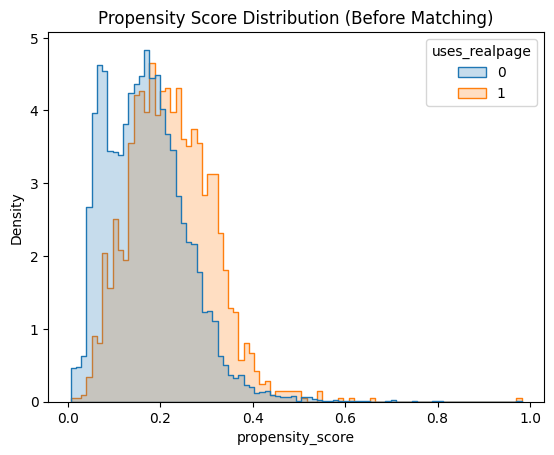

In [21]:


sns.histplot(df_psm, x="propensity_score", hue="uses_realpage", element="step", stat="density", common_norm=False)
plt.title("Propensity Score Distribution (Before Matching)")
plt.show()


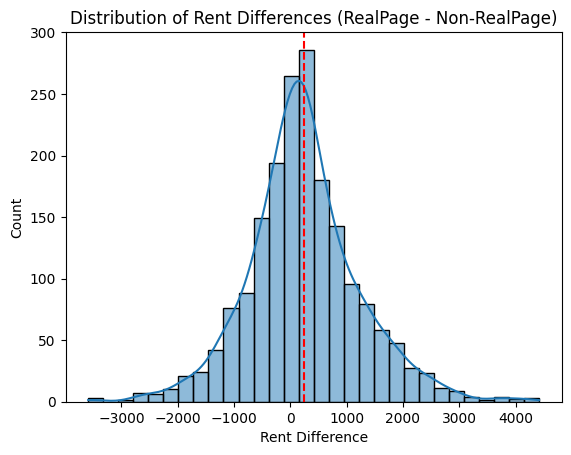

In [22]:
diff = treated_matched['MPF-RENT'].values - matched_control['MPF-RENT'].values

sns.histplot(diff, bins=30, kde=True)
plt.axvline(diff.mean(), color='red', linestyle='--')
plt.title("Distribution of Rent Differences (RealPage - Non-RealPage)")
plt.xlabel("Rent Difference")
plt.ylabel("Count")
plt.show()


In [23]:
print(f"Total matched pairs: {len(treated_matched)}")


Total matched pairs: 1860


In [25]:
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(treated_matched['MPF-RENT'], matched_control['MPF-RENT'])
print(f"T-stat: {t_stat:.3f}, p-value: {p_value:.4f}")


T-stat: 10.348, p-value: 0.0000


In [26]:
def standardized_mean_diff(treated, control, col):
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    pooled_std = np.sqrt((treated[col].var() + control[col].var()) / 2)
    return (mean_t - mean_c) / pooled_std

balance_stats = {
    col: standardized_mean_diff(treated_matched, matched_control, col)
    for col in covariates  # the list you matched on
}

balance_df = pd.Series(balance_stats).sort_values()
print(balance_df)


MPF-HIST-CONC-RATIO    -0.016669
MPF-OCC                -0.002372
averageSquareFootage   -0.000189
unitcount               0.012722
building_age            0.028639
stories                 0.064516
dtype: float64


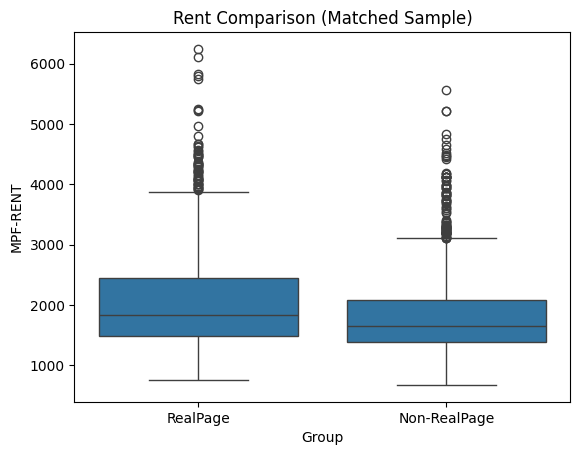

In [27]:

df_matched = pd.DataFrame({
    'Rent': pd.concat([treated_matched['MPF-RENT'], matched_control['MPF-RENT']]),
    'Group': ['RealPage'] * len(treated_matched) + ['Non-RealPage'] * len(matched_control)
})

sns.boxplot(x="Group", y="Rent", data=df_matched)
plt.title("Rent Comparison (Matched Sample)")
plt.ylabel("MPF-RENT")
plt.show()


# Supervised Residual Analysis

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind

# Load clean
df = pd.read_csv("cbsa_data_final_cleaned.csv", low_memory=False)
df = df.dropna()
exclude_cols = ["MPF-RENT", "uses_realpage", "propertyId", "data_index", "cbsa_code", "MPF-HIST-AVG-ASK-RPSF"]
features = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.float64, np.int64]]
# Target variable
target = "MPF-RENT"

assert target in df.columns and "uses_realpage" in df.columns
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Create DataFrame with results
df_results = pd.DataFrame({
    "actual_rent": y_test.values,
    "predicted_rent": y_pred,
    "residual": y_test.values - y_pred,
    "uses_realpage": df.loc[idx_test, "uses_realpage"].values
})


In [ ]:
# Mean residual difference
realpage_res = df_results[df_results["uses_realpage"] == 1]["residual"]
non_realpage_res = df_results[df_results["uses_realpage"] == 0]["residual"]

att_residual = realpage_res.mean() - non_realpage_res.mean()
print(f"Average Residual Difference (RealPage - Non-RealPage): ${att_residual:.2f}")


Average Residual Difference (RealPage - Non-RealPage): $1.85


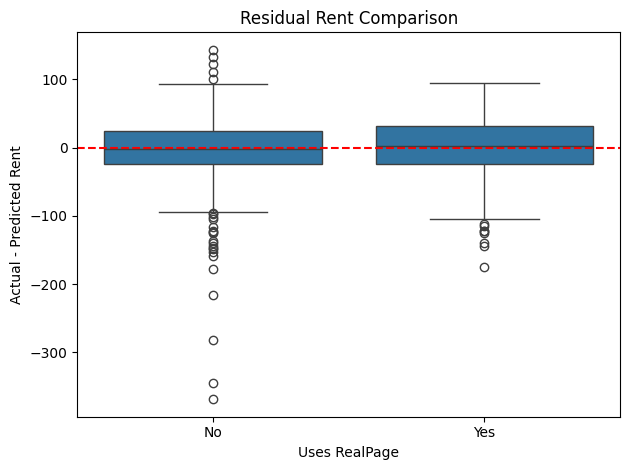

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="uses_realpage", y="residual", data=df_results)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Rent Comparison")
plt.xlabel("Uses RealPage")
plt.ylabel("Actual - Predicted Rent")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()


In [ ]:
t_stat, p_val = ttest_ind(realpage_res, non_realpage_res, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")


T-statistic: 0.411, p-value: 0.6816


Residual analysis is not statistically significant